In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style
import os
from pathlib import Path

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

## Part2 : Question 1

**Data loading and preprocessing**

In [2]:
import scipy.io as sio
from helpers import preprocess_subject

current_dir = os.getcwd()
subject_ids = range(1, 28)  # 1..27
subjects_preprocessed = {}

for sid in subject_ids:
    mat_path = os.path.join(current_dir, "Data", f"S{sid}", f"S{sid}_A1_E1.mat")  
    data = sio.loadmat(mat_path)
    subjects_preprocessed[sid] = preprocess_subject(data)

print("Processed subjects:", list(subjects_preprocessed.keys()))


Processed subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


**Accessing the preprocessed data for each subject**

- subjects_preprocessed[sid]["emg_lp"] : 
Low-pass filtered EMG envelope, shape (T, C)
→ T time samples, C channels.
- subjects_preprocessed[sid]["restimulus"] : 
Relabelled movement labels over time, shape (T,)
→ 0 = rest, 1..S = movements.
- subjects_preprocessed[sid]["rerepetition"] : 
Repetition index over time, shape (T,)
→ 0 = no repetition, 1..R = repetition number.
- subjects_preprocessed[sid]["unique_stimuli"] : 
Sorted array of movement labels (without rest), shape (S,).
- subjects_preprocessed[sid]["unique_reps"] : 
Sorted array of repetition indices (without 0), shape (R,).
- subjects_preprocessed[sid]["trial_masks"] : 
List of boolean masks over time, one mask per trial.
Each mask selects all time samples belonging to a given (movement, repetition) pair.
- subjects_preprocessed[sid]["trial_labels"] : 
Movement label for each trial, shape (n_trials,).
- subjects_preprocessed[sid]["trial_reps"] : 
Repetition index for each trial, shape (n_trials,).
- subjects_preprocessed[sid]["channel_var"] : 
Variance of the filtered EMG for each channel over the whole recording, shape (C,).
This is used for basic channel-quality inspection.

In [3]:
from helpers import compute_trial_activation_scores, find_suspicious_trials

all_scores = []
suspicious = {}

for sid, res in subjects_preprocessed.items():
    qc = compute_trial_activation_scores(
        res["emg_lp"], res["trial_masks"], res["trial_labels"], res["trial_reps"]
    )
    for s, lab, rep in zip(qc["scores"], qc["labels"], qc["reps"]):
        all_scores.append((sid, lab, rep, s))

    idx_bad = find_suspicious_trials(qc["scores"], 0.1, -3.5)
    suspicious[sid] = {
        "indices": idx_bad,
        "labels": qc["labels"][idx_bad],
        "reps":   qc["reps"][idx_bad],
        "scores": qc["scores"][idx_bad],
    }

all_scores = np.array(all_scores, dtype=object)

for sid, info in suspicious.items():
    n_bad = len(info["indices"])
    print(f"Subject {sid:2d}: {n_bad:2d} suspicious trial(s)")

Subject  1:  0 suspicious trial(s)
Subject  2:  0 suspicious trial(s)
Subject  3:  0 suspicious trial(s)
Subject  4:  0 suspicious trial(s)
Subject  5:  0 suspicious trial(s)
Subject  6:  0 suspicious trial(s)
Subject  7:  0 suspicious trial(s)
Subject  8:  0 suspicious trial(s)
Subject  9:  0 suspicious trial(s)
Subject 10:  0 suspicious trial(s)
Subject 11:  0 suspicious trial(s)
Subject 12:  0 suspicious trial(s)
Subject 13:  0 suspicious trial(s)
Subject 14:  0 suspicious trial(s)
Subject 15:  0 suspicious trial(s)
Subject 16:  0 suspicious trial(s)
Subject 17:  0 suspicious trial(s)
Subject 18:  0 suspicious trial(s)
Subject 19:  0 suspicious trial(s)
Subject 20:  0 suspicious trial(s)
Subject 21:  0 suspicious trial(s)
Subject 22:  0 suspicious trial(s)
Subject 23:  2 suspicious trial(s)
Subject 24:  0 suspicious trial(s)
Subject 25:  1 suspicious trial(s)
Subject 26:  0 suspicious trial(s)
Subject 27:  0 suspicious trial(s)


**Visualizing the suspicious trials for the subjects 23 and 25**

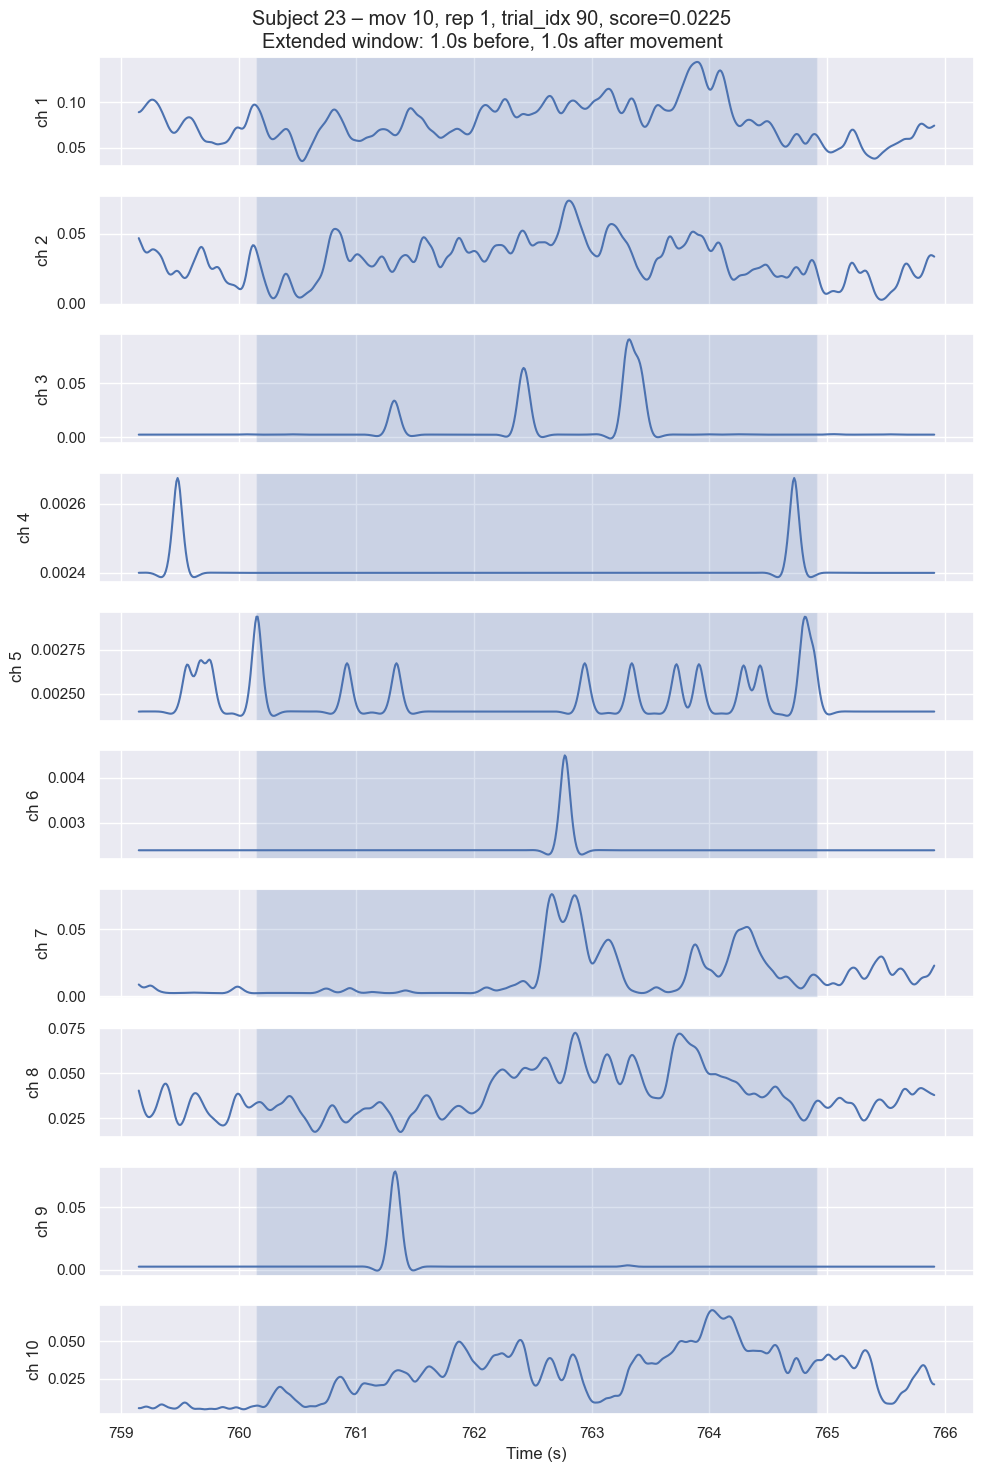

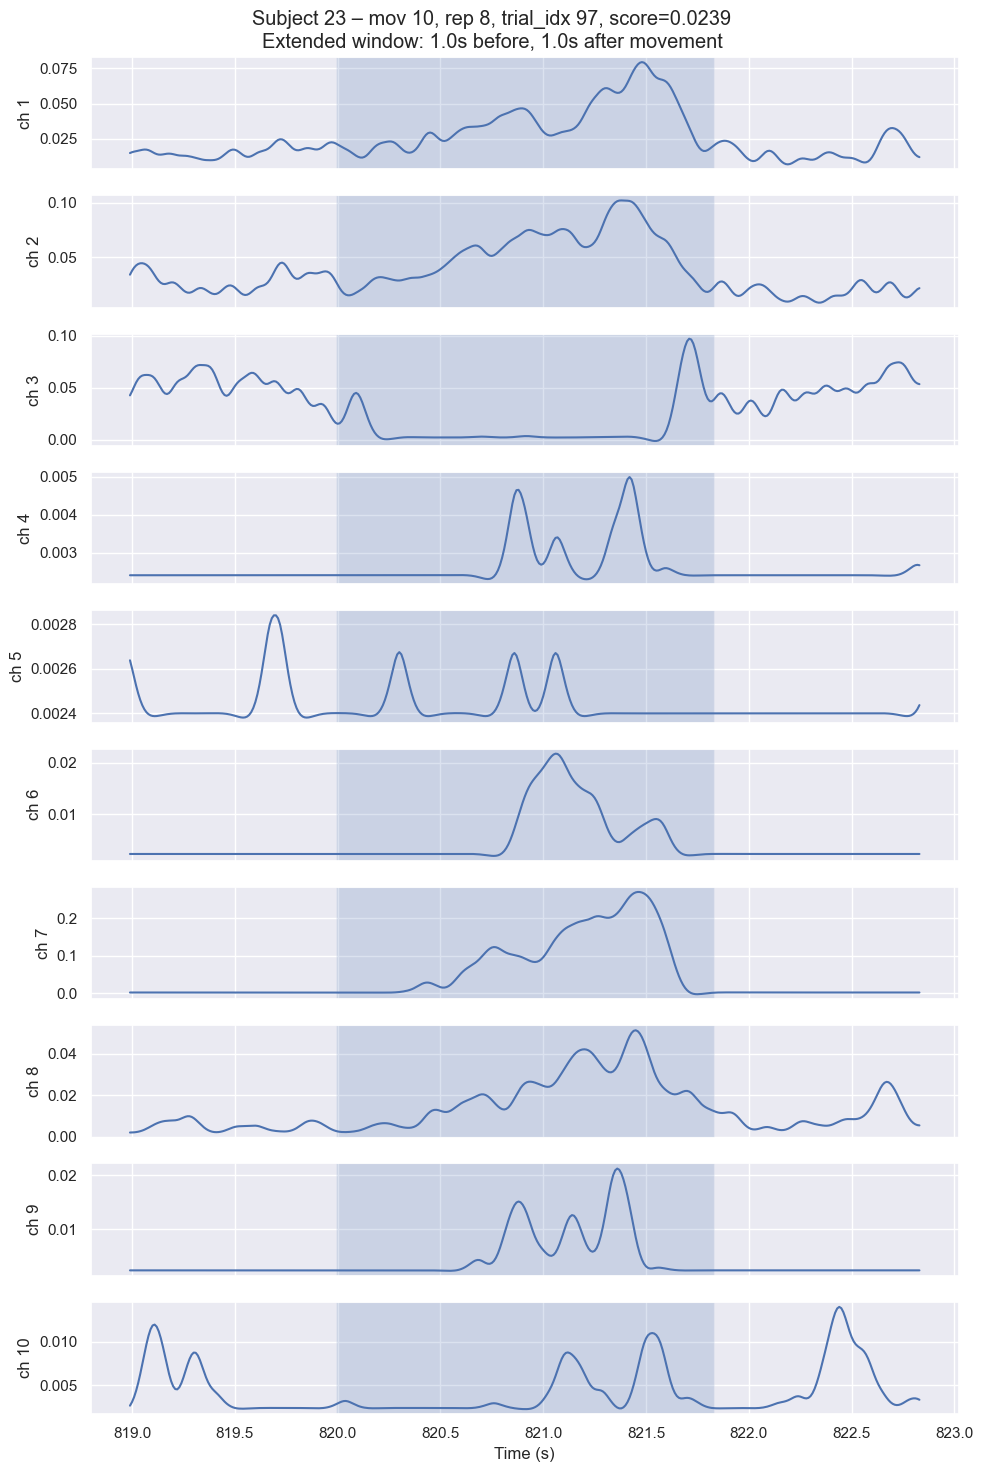

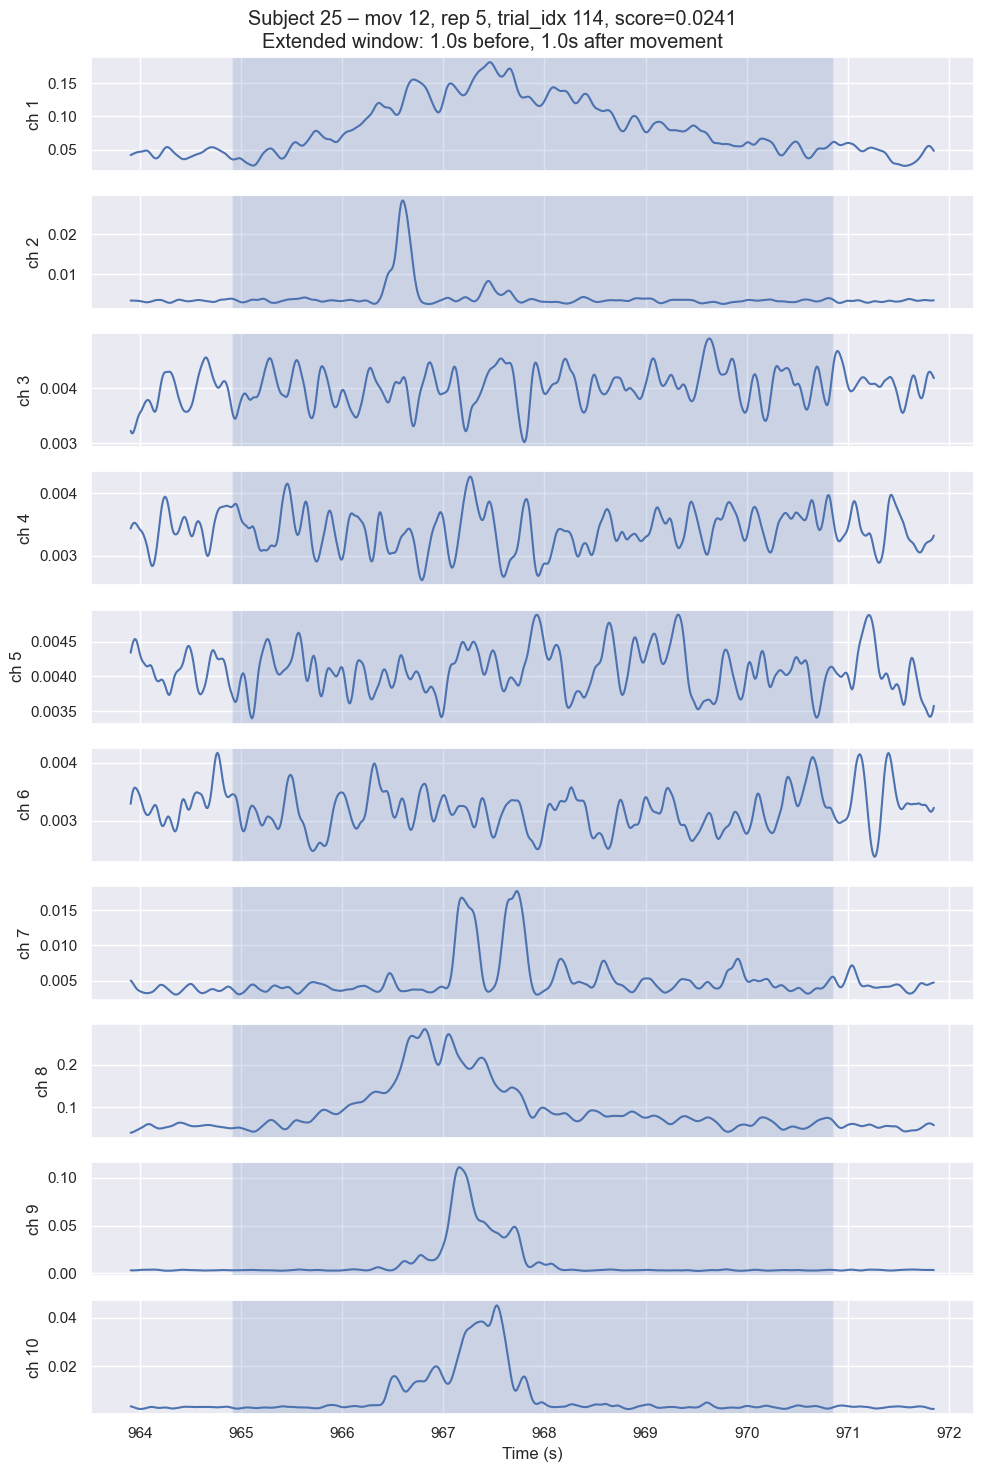

In [4]:
from helpers import plot_suspicious_trials_for_subject

plot_suspicious_trials_for_subject(23, suspicious, subjects_preprocessed)
plot_suspicious_trials_for_subject(25, suspicious, subjects_preprocessed)

In [14]:
sid = 25
res = subjects_preprocessed[sid]

channel_var = res["channel_var"]  # (n_channels,)

print(f"Subject {sid} – channel variances (whole recording):")
median_var = np.median(channel_var)
for ch, v in enumerate(channel_var, start=1):
    print(f"  ch {ch:2d}: var = {v:.4e}  ({v/median_var:5.2f} x median)")

Subject 25 – channel variances (whole recording):
  ch  1: var = 2.5451e-02  ( 0.48 x median)
  ch  2: var = 4.8254e-02  ( 0.91 x median)
  ch  3: var = 5.7804e-02  ( 1.09 x median)
  ch  4: var = 4.5026e-03  ( 0.08 x median)
  ch  5: var = 4.0393e-04  ( 0.01 x median)
  ch  6: var = 1.7168e-03  ( 0.03 x median)
  ch  7: var = 3.3714e-01  ( 6.36 x median)
  ch  8: var = 2.1481e-01  ( 4.05 x median)
  ch  9: var = 8.6150e-02  ( 1.62 x median)
  ch 10: var = 2.4966e-01  ( 4.71 x median)


For all 27 subjects (exercise 1), we applied the same preprocessing pipeline. The raw Ninapro EMG signals (already rectified and synchronized in the database) were low-pass filtered with a 2nd-order Butterworth filter at 5 Hz (zero-phase) to obtain a smooth EMG envelope. We then used the relabelled restimulus and rerepetition signals to segment the data into trials, where each trial corresponds to one movement and one repetition (movement s, repetition r). For each subject, we also computed the variance of the filtered EMG per channel and the set of unique movements and repetitions.

To assess channel quality, we inspected the channel-wise variance vector for each subject and identified channels with unusually low variance (e.g. channels 5–7 for subject 2, channels 4–6 for subject 25). However, when plotting the time courses of these channels with channel-specific scaling and aligning them with the movement labels, they still showed clear movement-related modulation (non-flat signals with bursts during active periods). We therefore interpreted them as low-amplitude but informative channels rather than dead electrodes, and we did not remove any channels from the analysis. Some channels (e.g. channels 3, 4, 6 and 9 for certain repetitions of movement 10 in subject 23) show a nearly flat baseline with a few sharp peaks during the movement window. This behaviour is consistent with low-level phasic activation or cross-talk from nearby muscles rather than dead electrodes: the channels are not constant over time and still show event-related modulation aligned with the movement label. Therefore we treat them as low-amplitude channels rather than corrupted channels.

To assess trial quality, we computed a simple activation score for each trial by averaging the low-pass filtered EMG over time and channels. Trials with extremely low scores relative to the subject’s distribution (e.g. <10% of the median activation or strong negative z-scores) were flagged as suspicious. Only a very small number of trials were flagged across all subjects, and visual inspection of these cases showed clear EMG bursts on several channels during the movement period, without any trial being completely flat or dominated by artefacts. As a result, we did not remove any trials from the multi-subject dataset.

Overall, after preprocessing and quality checks, the EMG data across all subjects appear reasonable and consistent with the expected muscle activations. All channels and trials are kept for the subsequent feature extraction and classification steps, while explicitly noting that some channels have lower variance and are likely less informative for certain movements.